In [2]:
import numpy as np
import h5py
import scipy.signal
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
from skimage.color import label2rgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import os
%matplotlib inline

using -95330.554688 as threshold for ct
using 0.139025 as threshold for pet
using -85539.281250 as threshold for ct
using 0.816090 as threshold for pet
using -95422.281250 as threshold for ct
using 0.085084 as threshold for pet
using -71642.640625 as threshold for ct
using 1.041283 as threshold for pet
using -96931.687500 as threshold for ct
using 0.160417 as threshold for pet


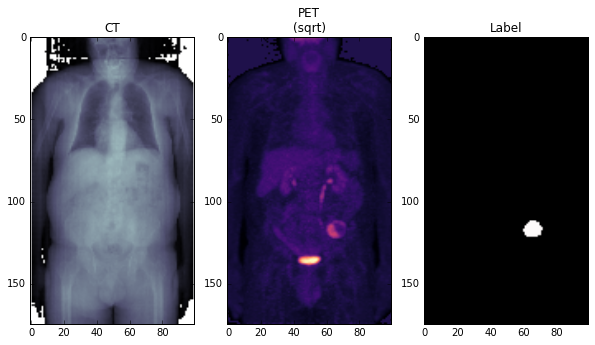

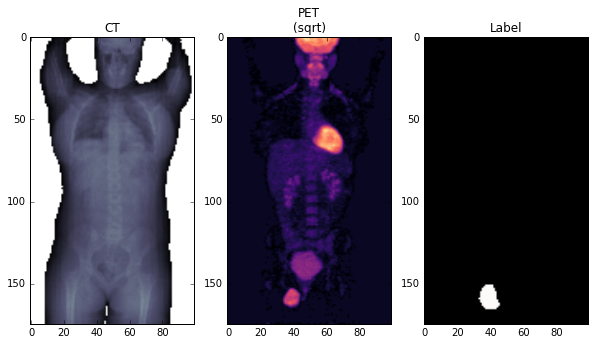

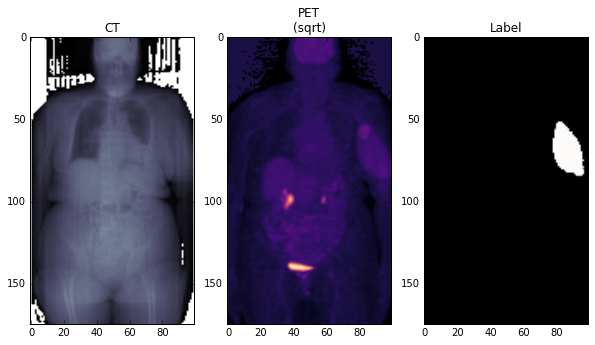

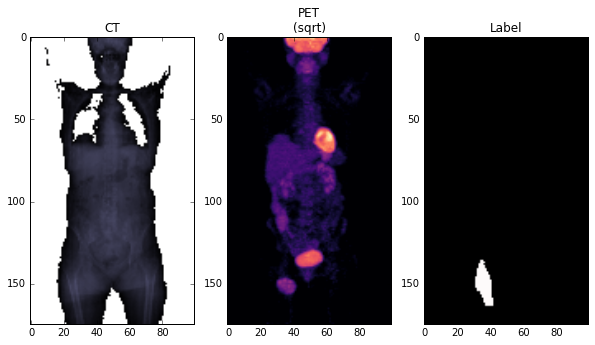

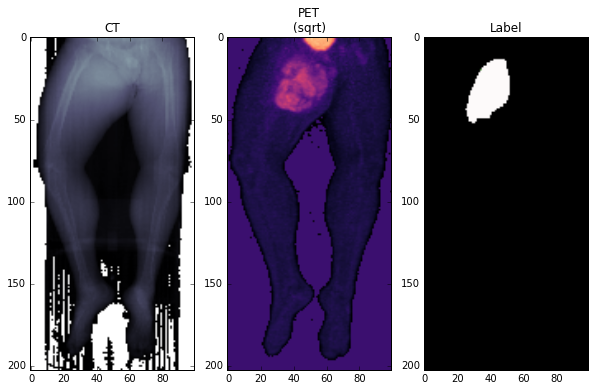

In [3]:
ct_data, pet_data, label_data = [], [], []
with h5py.File(os.path.join('..','input','lab_petct_vox_5.00mm.h5'),'r') as p_data:
    num=5
    #print(p_data['ct_data'].values()[0])
    for ct_img, pet_img, lab_img in zip(
                                   p_data['ct_data'].values(),
                                   p_data['pet_data'].values(),
                                   p_data['label_data'].values()
                                                           ):
        fig, (c_ax1, c_ax2, c_ax3) = plt.subplots(1, 3, figsize=(10, 10), dpi = 250)
        ct_data.append(np.sum(ct_img,1))
        pet_data.append(np.sum(pet_img,1))
        label_data.append(np.sum(lab_img,1))
        num=num-1
        
        css=np.sum(ct_img,1).squeeze()[::-1,:]
        threshold = np.max(css[0:10,0:10])
        print('using %f as threshold for ct' % threshold)
        css[np.where(css<threshold)] = 255
        c_ax1.imshow(css, cmap = 'bone')
        c_ax1.set_title('CT')
        c_ax1.axis('on')

        css=np.sqrt(np.max(pet_img,1)).squeeze()[::-1,:]
        threshold = np.max(css[0:10,0:10])
        print('using %f as threshold for pet' % threshold)
        css[np.where(css<threshold)] = 1
        c_ax2.imshow(css, cmap = 'magma')
        c_ax2.set_title('PET\n(sqrt)')
        c_ax2.axis('on')
        
        c_ax3.imshow(np.max(lab_img,1).squeeze()[::-1,:], cmap = 'gist_earth')
        c_ax3.set_title('Label')
        c_ax3.axis('on')
        if num == 0:
            break
    #print(pet_data[0].shape)
    #print(np.sum(pet_data[0],1).shape)
    #print(np.max(np.sum(pet_data[::-1,:],1)))
    

In [58]:
ct_tiles = []
pet_tiles = []
lab_tiles = []
tile_size=16
stride=3
for ct_img, pet_img, label in zip(ct_data, pet_data, label_data):
    for i in range(0,  ct_img.shape[0], tile_size):
        for j in range(0,  ct_img.shape[1], tile_size):
            for i_k in range(0, tile_size, stride):
                c=0
                for j_k in range(0, tile_size, stride):
                    c=c+1
                    ct_tiles += [ct_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size)]]
                    pet_tiles += [pet_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size)]]
                    lab_tiles += [label[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size)]]
l=len(pet_tiles) - 2772

(16, 16)


## Splitting tiles into training and validation set

In [71]:
ct_tiles = [c_tile for c_tile in ct_tiles[:l] if c_tile.shape == (tile_size,tile_size)]
pet_tiles = [c_tile for c_tile in pet_tiles[:l] if c_tile.shape == (tile_size,tile_size)]
lab_tiles = [c_tile for c_tile in lab_tiles[:l] if c_tile.shape == (tile_size,tile_size)]
ct_tiles_test = [c_tile for c_tile in ct_tiles[l:] if c_tile.shape == (tile_size,tile_size)]
pet_tiles_test = [c_tile for c_tile in pet_tiles[l:] if c_tile.shape == (tile_size,tile_size)]
lab_tiles_test = [c_tile for c_tile in lab_tiles[l:] if c_tile.shape == (tile_size,tile_size)]

#fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize=(50,50))
#ax1.imshow(montage2d(np.stack(n_ct_tiles,0)), cmap = 'bone')
#ax2.imshow(montage2d(np.stack(n_pet_tiles,0)), cmap = 'bone')
#ax3.imshow(montage2d(np.stack(n_lab_tiles,0)), cmap = 'gist_earth')
#ax4.imshow(montage2d(np.stack(n_ct_tiles2,0)), cmap = 'bone')
#ax5.imshow(montage2d(np.stack(n_pet_tiles2,0)), cmap = 'bone')
#ax6.imshow(montage2d(np.stack(n_lab_tiles2,0)), cmap = 'gist_earth')

## Removing predominantly black tiles

In [ ]:
ct_tiles_final, pet_tiles_final, lab_tiles_final = zip(*[(c_tile, p_tile, l_tile) 
      for c_tile, p_tile, l_tile in zip(ct_tiles, pet_tiles, lab_tiles)
     if np.max(ct_tile) > threshold_ct and np.max(pet_tile) > threshold_pet])


In [72]:
lab_score = [np.mean(c_tile) for c_tile in lab_tiles]
lab_score_test = [np.mean(c_tile) for c_tile in lab_tiles_test]
ct_tile_flat = [c_tile.flatten() for c_tile in ct_tiles_final]
ct_tile_flat_test = [c_tile.flatten() for c_tile in ct_tiles_test]
pet_tile_flat = [np.histogram(c_tile.flatten(),100)[0] for c_tile in pet_tiles_final]
pet_tile_flat_test = [np.histogram(c_tile.flatten(),100)[0] for c_tile in pet_tiles_test]
lab_class = [c_score > 0 for c_score in lab_score]
lab_class = [c_score > 0 for c_score in lab_score_test]


In [73]:
train_tiles, test_tile, train_score, test_score = np.stack(pet_tile_flat), np.stack(pet_tile_flat_test), lab_score, lab_score_test
#print('Training size', train_tiles.shape, 'Testing size', test_tile.shape)
#print('Train tumor tiles', np.where(train_score), 'Test tumor tiles', np.where(test_score))

In [74]:
from sklearn.neighbors import KNeighborsRegressor
knn1_model = KNeighborsRegressor(2, algorithm = 'kd_tree')

In [75]:
knn1_model.fit(train_tiles, train_score)

ValueError: Found input variables with inconsistent numbers of samples: [9587, 9920]

In [76]:
test_predictions = knn1_model.predict(test_tile)
#print('Predicted Results', test_predictions)
#print(np.array(train_score)[np.where(np.array(train_score)>5)])
print(knn1_model.kneighbors(np.array(test_tile),2))

NotFittedError: Must fit neighbors before querying.

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(test_score)>0, np.array(test_predictions)>0)

array([[1670,  120],
       [  97,   33]])

(-0.1, 1.1)

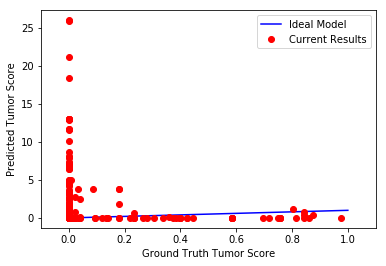

In [12]:
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1], [0,1], 'b-', label = 'Ideal Model')
ax1.plot(test_score, test_predictions, 'ro', label = 'Current Results')
ax1.set_xlabel('Ground Truth Tumor Score')
ax1.legend()
ax1.set_ylabel('Predicted Tumor Score')
ax1.set_xlim(-0.1,1.1)

In [13]:
f1score = f1_score(np.array(test_score)>0, np.array(test_predictions)>0)
print(f1score)

0.233215547703


In [14]:
rscore=roc_auc_score(np.array(test_score)>0, np.array(test_predictions)>0)
print(rscore)

0.59340352385
